In [1]:
import torch
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

We start by loading the model from HuggingFace using the JATIC-toolbox.

In [2]:
import jatic_toolbox

model = jatic_toolbox.load_model(
    provider="huggingface",
    model_name="Kaludi/food-category-classification-v2.0",
    task="image-classification"
)


/home/msw/.virtualenvs/cdao/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/msw/.virtualenvs/cdao/lib/python3.10/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


The model returns a `HuggingFaceProbs` object type, but ART expects the model output to be the `y` tensor. So we have to adapt the model to produce the correct output.

In [3]:
from charmory.utils import adapt_jatic_image_classification_model_for_art

adapt_jatic_image_classification_model_for_art(model)

We then move the model to the target runtime device and wrap it in an ART classifier to make it compatible with Armory/ART.

In [4]:
from art.estimators.classification import PyTorchClassifier

model.to(DEVICE)

classifier = PyTorchClassifier(
    model,
    loss=torch.nn.CrossEntropyLoss(),
    optimizer=torch.optim.Adam(model.parameters(), lr=0.003),
    input_shape=(224, 224, 3),
    channels_first=False,
    nb_classes=12,
    clip_values=(0.0, 1.0),
)

Next we load the dataset from from HuggingFace using the JATIC-toolbox.

In [5]:
dataset = jatic_toolbox.load_dataset(
    provider="huggingface",
    dataset_name="Kaludi/food-category-classification-v2.0",
    task="image-classification",
    split="validation",
)

/home/msw/.virtualenvs/cdao/lib/python3.10/site-packages/datasets/load.py:2083: FutureWarning: 'task' was deprecated in version 2.13.0 and will be removed in 3.0.0.

  warnings.warn(
Resolving data files: 100%|██████████| 303/303 [00:00<00:00, 720858.83it/s]


Since this dataset contains bad images that will result in errors during evaluation, we will apply a filter to the underlying HuggingFace dataset.

In [6]:
from transformers.image_utils import infer_channel_dimension_format
import numpy as np

def filter(sample):
    try:
        infer_channel_dimension_format(np.asarray(sample["image"]))
        return True
    except Exception as err:
        print(err)
        return False

print(f"Dataset length prior to filtering: {len(dataset)}")
dataset._dataset = dataset._dataset.filter(filter)
print(f"Dataset length after filtering: {len(dataset)}")

Dataset length prior to filtering: 300
Dataset length after filtering: 280


chosen_labels={2, 3, 4, 5, 6, 7, 8, 9, 11}


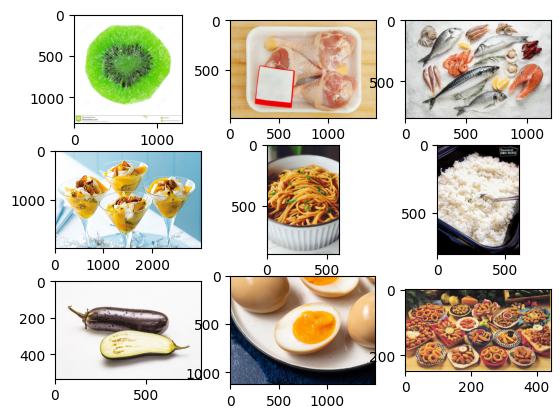

In [7]:
import charmory.display
charmory.display.show_samples(dataset, samples=9)

Then prepare a transform for the data using the preprocessor that comes with the model.

In [8]:
from charmory.utils import create_jatic_image_classification_dataset_transform

transform = create_jatic_image_classification_dataset_transform(model.preprocessor)
dataset.set_transform(transform)

Then we create an Armory data generator around the dataset.

In [9]:
from charmory.data import JaticVisionDatasetGenerator

generator = JaticVisionDatasetGenerator(
    dataset=dataset,
    batch_size=16,
    epochs=1,
)

Lastly we will define the Armory evaluation, including the attack and scenario to be run.

In [10]:
import art.attacks.evasion
from charmory.evaluation import (
    Attack,
    Dataset,
    Evaluation,
    Metric,
    Model,
    Scenario,
    SysConfig,
)
import charmory.scenarios.image_classification

eval_dataset = Dataset(
    name="food-category-classification",
    test_dataset=generator,
)

eval_model = Model(
    name="food-category-classification",
    model=classifier,
)

eval_attack = Attack(
    name="PGD",
    attack=art.attacks.evasion.ProjectedGradientDescent(
        classifier,
        batch_size=1,
        eps=0.031,
        eps_step=0.007,
        max_iter=20,
        num_random_init=1,
        random_eps=False,
        targeted=False,
        verbose=False,
    ),
    use_label_for_untargeted=True,
)

eval_scenario = Scenario(
    function=charmory.scenarios.image_classification.ImageClassificationTask,
    kwargs={},
)

eval_metric = Metric(
    profiler_type="basic",
    supported_metrics=["accuracy"],
    perturbation=["linf"],
    task=["categorical_accuracy"],
    means=True,
    record_metric_per_sample=False,
)

eval_sysconfig = SysConfig(
    gpus=["all"],
    use_gpu=True,
)

evaluation = Evaluation(
    name="food-category-classification",
    description="Food category classification from HuggingFace",
    author="Kaludi",
    dataset=eval_dataset,
    model=eval_model,
    attack=eval_attack,
    scenario=eval_scenario,
    metric=eval_metric,
    sysconfig=eval_sysconfig,
)

We now create an engine for the evaluation and run it.

In [11]:
from charmory.engine import Engine
from pprint import pprint

engine = Engine(evaluation)
results = engine.run()
pprint(results)

Evaluation: 100%|██████████| 18/18 [06:59<00:00, 23.29s/it]

2023-08-07 07:39:03 6m59s METRIC   armory.instrument.instrument:_write:742 benign_mean_categorical_accuracy on benign examples w.r.t. ground truth labels: 0.961
2023-08-07 07:39:03 6m59s METRIC   armory.instrument.instrument:_write:742 adversarial_mean_categorical_accuracy on adversarial examples w.r.t. ground truth labels: 0.496
{'armory_version': '23.7.2.post80+gd5aa682b.d20230807',
 'evaluation': Evaluation(name='food-category-classification',
                          description='Food category classification from '
                                      'HuggingFace',
                          model=Model(name='food-category-classification',
                                      model=art.estimators.classification.pytorch.PyTorchClassifier(model=ModelWrapper(
  (_model): HuggingFaceImageClassifier(
    (model): SwinForImageClassification(
      (swin): SwinModel(
        (embeddings): SwinEmbeddings(
          (patch_embeddings): SwinPatchEmbeddings(
            (projection): Conv2